In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

In [98]:
df=pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
df=df.rename(columns={'aggregated_value':'count', 'country':'Mention_country', 'affiliation_country':'Aff_country'})

df=df[df['year'].isin(np.arange(2003, 2019, 1))]
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
rev_Country_list={Country_list[key]: key for key in Country_list}
abbr=[country.lower() for country in Country_list.values()]
physical_sciences=[ 'MATH', 'ENGI', 'PHYS', 'COMP','MULT']
df=df[~df['subjarea'].isin(physical_sciences)]
df['year_arabspring']=df['year'].apply(lambda x: 'before' if x>=2003 and x<=2010 else 'after' )
df['is_internal_attention']=df['Mention_country']==df['Aff_country']
result_df=df.groupby(['Mention_country', 'year_arabspring', 'is_internal_attention'])['count'].sum().reset_index()


In [130]:
# Group by `cat` and `Mention_country` and compute the ratio of `count` for `is_internal_attention=False` to the total `count` for each group
df_grouped = (
    result_df.groupby([ "Mention_country", "year_arabspring"])
    .apply(lambda x: x.loc[x["is_internal_attention"] == False, "count"].sum() / x.loc[x["is_internal_attention"] == True, "count"].sum())
    .reset_index(name="Foriegn2Internal_attention_ratio")
)

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_40764\1104022864.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  .apply(lambda x: x.loc[x["is_internal_attention"] == False, "count"].sum() / x.loc[x["is_internal_attention"] == True, "count"].sum())
C:\Users\Yasaman\AppData\Local\Temp\ipykernel_40764\1104022864.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x["is_internal_attention"] == False, "count"].sum() / x.loc[x["is_internal_attention"] == True, "count"].sum())


In [131]:
df_grouped.query(f'Mention_country in @abbr')

,Mention_country,year_arabspring,Foriegn2Internal_attention_ratio
90,bhr,after,0.509066
91,bhr,before,0.431108
177,egy,after,0.517819
178,egy,before,0.700478
269,jor,after,0.768732
270,jor,before,0.689428
287,kwt,after,0.469842
288,kwt,before,0.272642
295,lby,after,4.253802
296,lby,before,1.957113


C:\Users\Yasaman\AppData\Local\Temp\ipykernel_40764\2334229257.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Mention_country'] = subset['Mention_country'].map(rev_Country_list)
C:\Users\Yasaman\AppData\Local\Temp\ipykernel_40764\2334229257.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['sorted_order'] = subset['Mention_country'].apply(lambda x: country_names.index(x))
C:\Users\Yasaman\AppData\Local\Temp\ipykernel_40764\2334229257.py:12: SettingWithCopyWarning: 
A value is trying 

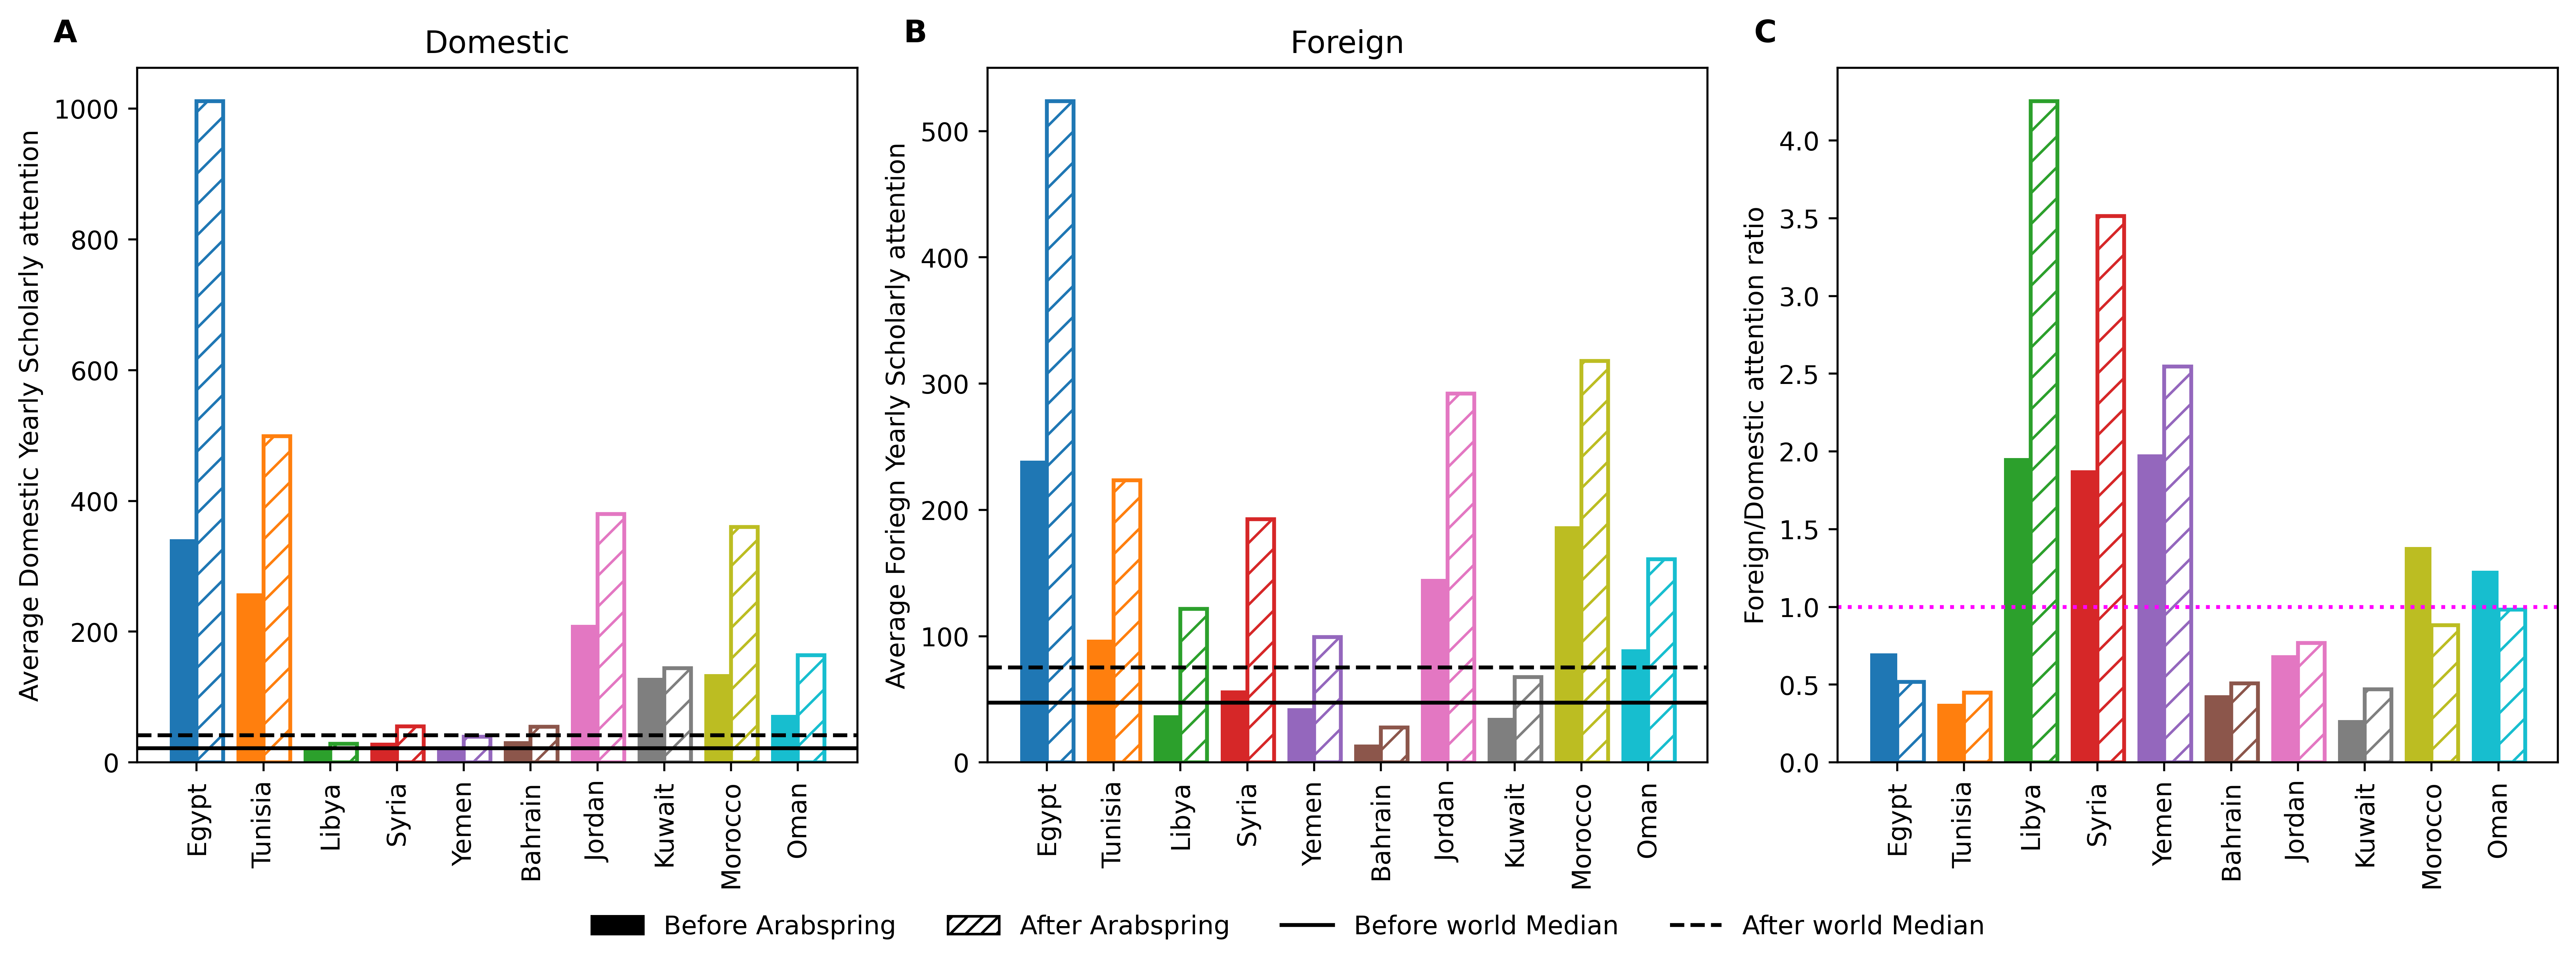

In [147]:
Country_list = {'Egypt':'EGY', 'Tunisia':'TUN', 'Libya':'LBY', 'Syria':'SYR', 'Yemen':'YEM',
                'Bahrain':'BHR', 'Jordan':'JOR', 'Kuwait':'KWT', 'Morocco':'MAR', 'Oman':'OMN'}
rev_Country_list = {Country_list[key].lower(): key for key in Country_list}
country_names = list(Country_list.keys())
custom_colors = [f'C{i}' for i in range(10)]
fig, ax=plt.subplots(nrows=1,ncols=3, figsize=(14, 5), dpi=500)
Titles=['Domestic', 'Foreign']
subplot_labels = ['A', 'B', 'C', 'D']

for i, is_internal in enumerate([True, False]):
    subset = result_df.query(f'is_internal_attention == {is_internal} and Mention_country in @abbr')
    subset['Mention_country'] = subset['Mention_country'].map(rev_Country_list)
    subset['sorted_order'] = subset['Mention_country'].apply(lambda x: country_names.index(x))
    subset = subset.sort_values('sorted_order').drop(columns=['sorted_order'])

    # Reset the index if needed
    subset.reset_index(drop=True, inplace=True)
    x_labels = subset['Mention_country'].unique()
    x = np.arange(len(x_labels))  # X positions for the bars
    subset['count']/=8
    width = 0.4  # Width of each bar
    before_data = subset[subset['year_arabspring'] == 'before']['count']
    after_data = subset[subset['year_arabspring'] == 'after']['count']
    
    ax[i].bar(
        x - width / 2, 
        before_data, 
        width=width, 
        color=custom_colors, 
        label='Before'
    )
    
    # Bars for 'after' with dashed patterns
    ax[i].bar(
        x + width / 2, 
        after_data, 
        width=width, 
        color='none', 
        edgecolor=custom_colors, 
        linewidth=1.5, 
        hatch='//', 
        label='After'
    )
    medians=result_df.query(f'is_internal_attention == {is_internal}').groupby('year_arabspring')['count'].median().to_dict()

    ax[i].axhline(medians['before']/8, color='k')
    ax[i].axhline(medians['after']/8, color='k', linestyle='--')
    
    # Set x-axis labels and title
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(x_labels, rotation=90)
    ax[i].set_title(Titles[i])
    #ax[i].set_ylim(0, 3500)
    
    # Add subplot label (A, B, C, D) to the top-left corner
    ax[i].text(-0.1, 1.05, subplot_labels[i], transform=ax[i].transAxes, fontsize=12, fontweight='bold', va='center', ha='center')

ax[0].set_ylabel('Average Domestic Yearly Scholarly attention')
    
ax[1].set_ylabel('Average Foriegn Yearly Scholarly attention')


subset = df_grouped.query(f'Mention_country in @abbr')
subset['Mention_country'] = subset['Mention_country'].map(rev_Country_list)
subset['sorted_order'] = subset['Mention_country'].apply(lambda x: country_names.index(x))
subset = subset.sort_values('sorted_order').drop(columns=['sorted_order'])

# Reset the index if needed
subset.reset_index(drop=True, inplace=True)
x_labels = subset['Mention_country'].unique()
x = np.arange(len(x_labels))  # X positions for the bars
width = 0.4  # Width of each bar
before_data = subset[subset['year_arabspring'] == 'before']['Foriegn2Internal_attention_ratio']
after_data = subset[subset['year_arabspring'] == 'after']['Foriegn2Internal_attention_ratio']

ax[2].bar(
    x - width / 2, 
    before_data, 
    width=width, 
    color=custom_colors, 
    label='Before'
)

# Bars for 'after' with dashed patterns
ax[2].bar(
    x + width / 2, 
    after_data, 
    width=width, 
    color='none', 
    edgecolor=custom_colors, 
    linewidth=1.5, 
    hatch='//', 
    label='After'
)

ax[2].axhline(1, color='magenta', linestyle=':')

# Set x-axis labels and title
ax[2].set_xticks(x)
ax[2].set_xticklabels(x_labels, rotation=90)
#ax[i].set_ylim(0, 3500)

# Add subplot label (A, B, C, D) to the top-left corner
ax[2].text(-0.1, 1.05, 'C', transform=ax[2].transAxes, fontsize=12, fontweight='bold', va='center', ha='center')
ax[2].set_ylabel('Foreign/Domestic attention ratio')
    




# Create custom legend handles for the boxes
solid_box = mpatches.Patch(facecolor='k', edgecolor='k', label='Before Arabspring')  # Solid box
dashed_box = mpatches.Patch(facecolor='white', edgecolor='k', hatch='////', label='After Arabspring')  # Dashed pattern inside
    # Create custom legend handles with grey color
before_handle = mlines.Line2D([], [], color='k', label='Before world Median')
after_handle = mlines.Line2D([], [], color='k', label='After world Median', linestyle='--')

    # Add the legend with custom handles
fig.legend(handles=[solid_box, dashed_box, before_handle,after_handle], loc='lower center', frameon=False, ncol=4,bbox_to_anchor=(0.5, -0.05))


plt.tight_layout()
plt.show()


In [ ]:
medians=result_df.query(f'cat == "{category}"').groupby('year_arabspring')['count'].median().to_dict()

ax[i].axhline(medians['before'], color='k')
ax[i].axhline(medians['after'], color='k', linestyle='--')

# Set x-axis labels and title
ax[i].set_xticks(x)
ax[i].set_xticklabels(x_labels, rotation=90)
ax[i].set_title(category)
ax[i].set_ylim(0, 3500)

# Add subplot label (A, B, C, D) to the top-left corner
ax[i].text(-0.1, 1.05, subplot_labels[i], transform=ax[i].transAxes, fontsize=12, fontweight='bold', va='center', ha='center')
ax[i].set_ylabel('Scholarly attention')
# Create custom legend handles for the boxes
solid_box = mpatches.Patch(facecolor='k', edgecolor='k', label='Before Arabspring')  # Solid box
dashed_box = mpatches.Patch(facecolor='white', edgecolor='k', hatch='////', label='After Arabspring')  # Dashed pattern inside
    # Create custom legend handles with grey color
before_handle = mlines.Line2D([], [], color='k', label='Before world Median')
after_handle = mlines.Line2D([], [], color='k', label='After world Median', linestyle='--')

# Add the legend with custom handles
fig.legend(handles=[solid_box, dashed_box, before_handle,after_handle], loc='lower center', frameon=False, ncol=4,bbox_to_anchor=(0.5, -0.05))


C:\Users\Yasaman\AppData\Local\Temp\ipykernel_40764\3944084289.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x["is_internal_attention"] == False, "count"].sum() / x["count"].sum())


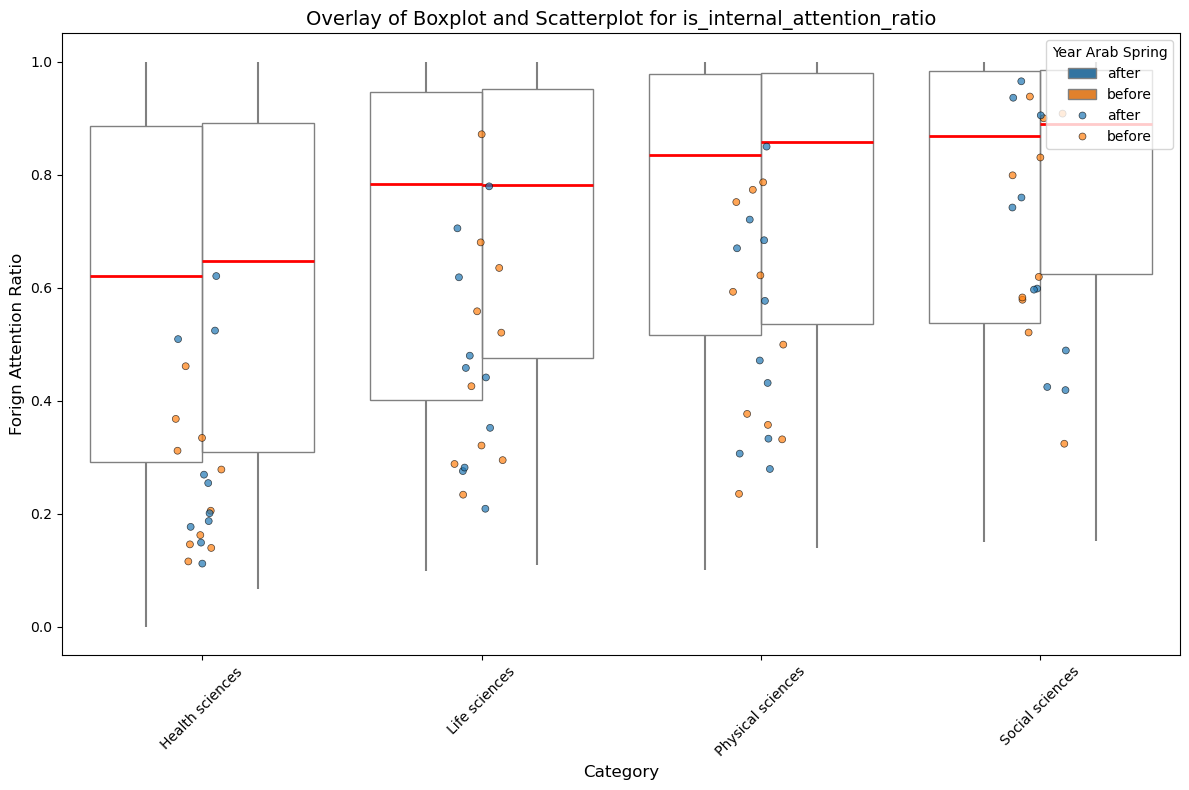

In [54]:
# Filter out undefined categories
df_filtered = df_grouped.query('cat != "undefined"')

# Create a figure
plt.figure(figsize=(12, 8))

# Plot the boxplot
sns.boxplot(
    data=df_filtered,
    x='cat',
    y='is_internal_attention_ratio',
    hue='year_arabspring',
    dodge=True,  # Avoid overlapping hues in boxplots
    showcaps=False,  # Optionally hide the caps
    boxprops={'facecolor': 'None', 'edgecolor': 'gray'},  # Transparent fill for boxes
    whiskerprops={'linewidth': 1.5, 'color': 'gray'},  # Styling whiskers
    medianprops={'linewidth': 2, 'color': 'red'}  # Styling median lines
)

# Plot the scatterplot on top of the boxplot
df_scatter = df_filtered[df_filtered['Mention_country'].isin(abbr)]
sns.stripplot(
    data=df_scatter,
    x='cat',
    y='is_internal_attention_ratio',
    hue='year_arabspring',
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5,
    marker='o'
)

# Adjust the layout
plt.title('Overlay of Boxplot and Scatterplot for is_internal_attention_ratio', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Forign Attention Ratio', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the legend
plt.legend(loc='upper right', title='Year Arab Spring')

# Display the plot
plt.show()


In [50]:
# Pivot the table to bring "before" and "after" as columns
pivoted_df = df_filtered.pivot(index=["cat", "Mention_country"], columns="year_arabspring", values="is_internal_attention_ratio").reset_index()

# Rename columns for clarity
pivoted_df.columns.name = None  # Remove the multiindex column name
pivoted_df.rename(columns={"after": "after_ratio", "before": "before_ratio"}, inplace=True)

pivoted_df['difference_ratio']=pivoted_df['after_ratio']-pivoted_df['before_ratio']

In [58]:
pivoted_df

,cat,Mention_country,after_ratio,before_ratio,difference_ratio
0,Health sciences,Cape Verde,1.000000,1.000000,0.000000
1,Health sciences,Curacao,1.000000,1.000000,0.000000
2,Health sciences,East Timor,1.000000,1.000000,0.000000
3,Health sciences,Falkland Islands,1.000000,1.000000,0.000000
4,Health sciences,Ivory Coast,1.000000,1.000000,0.000000
...,...,...,...,...,...
1052,Social sciences,yem,0.904863,0.907940,-0.003077
1053,Social sciences,yug,1.000000,0.990895,0.009105
1054,Social sciences,zaf,0.250125,0.337319,-0.087194
1055,Social sciences,zmb,0.806998,0.810726,-0.003728


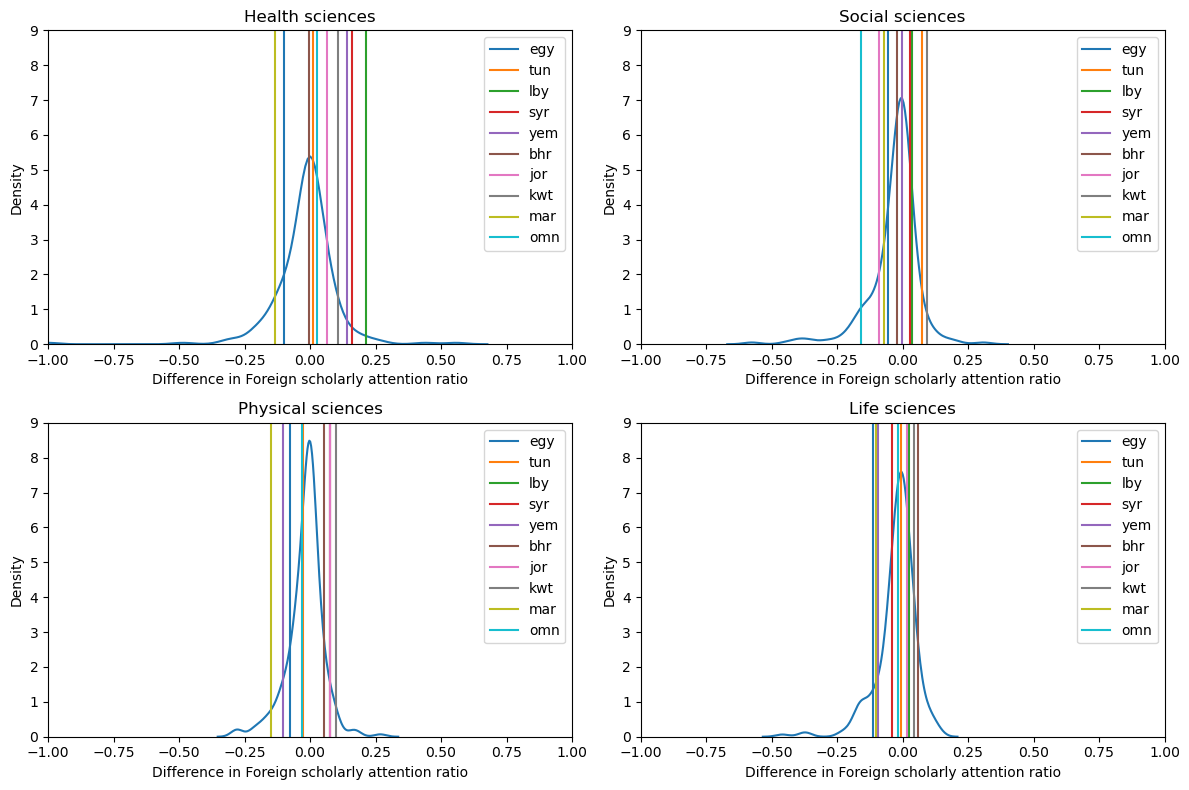

In [87]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
ax=ax.flat
for i, category in enumerate(['Health sciences', 'Social sciences', 'Physical sciences', 'Life sciences']):
    subset = pivoted_df.query(f'cat == "{category}"')
    ax[i].set_title(category)
    sns.kdeplot(subset, x='difference_ratio', ax=ax[i])
    for k, c in enumerate(abbr):
        ax[i].axvline(subset[subset['Mention_country']==c].iloc[0]['difference_ratio'], color=f'C{k}', label=c)
    ax[i].set_xlim(-1,1)
    ax[i].set_ylim(0,9)
    ax[i].legend()
    ax[i].set_xlabel('Difference in Foreign scholarly attention ratio')

plt.tight_layout()

In [75]:
subset[subset['Mention_country']=='yem'].iloc[0]['difference_ratio']

0.14119902588837852

In [72]:
subset[subset['Mention_country']=={c}]

,cat,Mention_country,after_ratio,before_ratio,difference_ratio


,cat,Mention_country,after_ratio,before_ratio,difference_ratio
83,Health sciences,egy,0.176573,0.278019,-0.101446


In [56]:
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}


['egy', 'tun', 'lby', 'syr', 'yem', 'bhr', 'jor', 'kwt', 'mar', 'omn']